## Prophet Forcasting

In this notebook we will use Prohphet Library that provide completely automated forecast, and to tune the parameters of the prophet model we will use Optuna to automatize the tuninng of parameters.





In other terms this notebook will be about using a library which will automate the forecasting

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import optuna
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import joblib
import glob

c:\Users\Zakaria Bouchegoura\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


#### Global Var :

In [2]:
PATH = r'C:\Users\Zakaria Bouchegoura\Desktop\Nouveau dossier (5)\archive\stock_market_data\nasdaq\csv'
n_trials = 10 # Number of trials by optuna to find the optimal parameters

### Loading All Stock Market :

For correct usage of prophet.lib its require to put the index of the dataset as Date.time type and use only two clomuns 

ds = date and y = close price

In [3]:
# getting path's of all datasets
datasets_files = glob.glob(PATH + "/*.csv")

datasets = {} # dictionary to save each stock-market dataset by its Index

for filename in datasets_files:

    #getting the Index of the stock
    stock_name=filename.split("\\")[-1][:-4] 

    #Processing data
    df = pd.read_csv(filename, index_col=None, header=0)
    datetime_series = pd.to_datetime(df['Date'],dayfirst=True)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df["Date"]=datetime_series
    df2=df.set_index(datetime_index)
    df2.drop(['Low', 'Open', 'Volume', 'High', 'Adjusted Close'], axis=1, inplace=True)
    df2.columns=['ds','y']
    df2=df2.dropna()
    datasets[stock_name]=df2

In [4]:
# adding to the global environment, global variables of each stock market called by its stock index
locals().update(datasets) 

#### chosing one Stock for the study

The prediction and optimization process takes about 5 min per action for 10 trials.

The task is time-consuming, we will conduct the study on a single stock market action and we choose Apple Stock.

The idea will be the same for the rest of stocks.

In [5]:
data=AAPL.copy()

In [ ]:
data=data.sample(frac=1)

#### Preparing Optuna 

We define a function who take the parameters that we want tune for the model Prophet, we use the mean average error to compare the different models.

In [59]:
def objective(trial):

    """ 
    trials = Number of trials by optuna to find the optimal parameters
    
    """
    # params contains the parameters that we want tune for the model

    params = {
                'n_changepoints': trial.suggest_int('n_changepoints', 10, 30),

                'changepoint_range':  trial.suggest_float('changepoint_range', 0.7, 0.9),

                'yearly_seasonality': trial.suggest_int('yearly_seasonality', 10, 50),

                'weekly_seasonality': trial.suggest_int('weekly_seasonality', 10, 50),

                'daily_seasonality': trial.suggest_int('daily_seasonality', 10, 50),

                'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
                
                }


    
    model = Prophet(**params) # model is Prophet class object
    model.fit(data[:'2022-05-28'])
    preds = model.predict(data[:'2022-05-28'])
    
    mae_score = mean_absolute_error(data[:'2022-05-28']['y'], preds['yhat'])
    return mae_score

#### Initiate optuna with 10 trials.

In [60]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2022-10-19 17:00:34,784] A new study created in memory with name: no-name-b2e07977-a7ef-4ea5-8ced-7e1ef014750a
17:00:36 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2022-10-19 17:01:04,317] Trial 0 finished with value: 8.386501702571207 and parameters: {'n_changepoints': 28, 'changepoint_range': 0.5534920510716621, 'yearly_seasonality': 10, 'weekly_seasonality': 32, 'daily_seasonality': 15, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 8.386501702571207.
17:01:05 - cmdstanpy - INFO - Chain [1] start processing
17:01:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2022-10-19 17:01:36,936] Trial 1 finished with value: 6.433529471906401 and parameters: {'n_changepoints': 15, 'changepoint_range': 0.6925953710017331, 'yearly_seasonality': 33, 'weekly_seasonality': 41, 'daily_seasonality': 13, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 6.433529471906401.
17:01:38 - cmdstanpy - I

In [61]:
dict_best=study.best_params # Getting the best parameter with smallest MAE

In [62]:
dict_best

{'n_changepoints': 16,
 'changepoint_range': 0.79787756005617,
 'yearly_seasonality': 50,
 'weekly_seasonality': 37,
 'daily_seasonality': 35,
 'seasonality_mode': 'multiplicative'}

#### Manual Calibration

I modified the two parameters "n_changepoints" and "changepoint_range" manually after the optimization of Optuna, because during the calibration of the Optuna model I reduced the number of these parameters, to reduce the calculation time.

The second motivation is to add "n_changepoints" is to better capture the stochastic behavior of the time series, without overfitting it.

In [82]:
dict_best_upgraded=dict_best.copy()

In [88]:
# two modifications to better catch the stochastic behavior
dict_best_upgraded["n_changepoints"]=50
dict_best_upgraded["changepoint_range"]=0.9

In [89]:
dict_best_upgraded

{'n_changepoints': 50,
 'changepoint_range': 0.9,
 'yearly_seasonality': 50,
 'weekly_seasonality': 37,
 'daily_seasonality': 35,
 'seasonality_mode': 'multiplicative'}

#### Fitting a prophet with best parameters

18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing


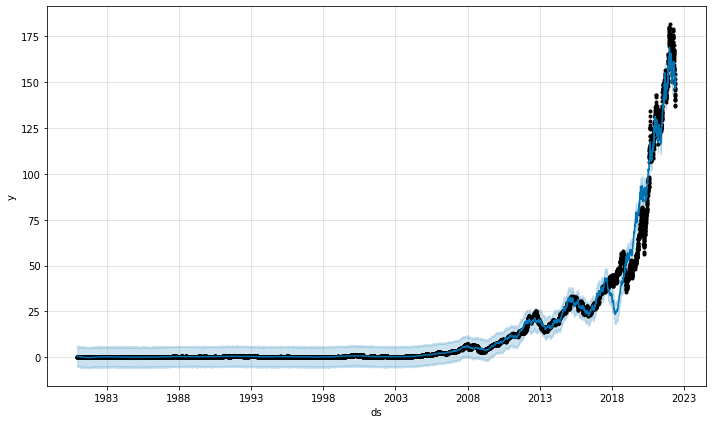

In [90]:
final_model = Prophet(**dict_best_upgraded)
final_model.fit(data[:'2022-05-28'])
forecast = final_model.predict(data)
fig1 = final_model.plot(forecast)

#### Plotting the prediction

Saving the prediction values to plot compartive between real and predition

In [91]:
prediction=forecast['yhat'][-5:].values
prediction_low=forecast['yhat_lower'][-5:].values
prediction_up=forecast['yhat_upper'][-5:].values


In [92]:
real_values=data['2022-05-28':'2022-06-06']['y'].values
index_prediction=data['2022-05-28':'2022-06-06'].index

In [93]:
study_resume=pd.DataFrame({'prediction':prediction,'prediction_low':prediction_low,'prediction_upper':prediction_up,'real':real_values}
                    ,index=index_prediction)

Comparing and ploting the forecasting and real values

In [94]:
study_resume[['prediction','real']]

,prediction,real
2022-05-31,148.761559,148.839996
2022-06-01,148.743671,148.710007
2022-06-02,148.747174,151.210007
2022-06-03,149.748225,145.380005
2022-06-06,153.459155,148.410004


<AxesSubplot:>

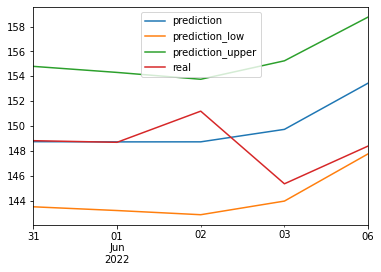

In [95]:
study_resume.plot.line()

### synthesis

The prophet model seems to be promising with its approach to automatize many of the classic approaches, such as seasonality detection and trend-changing points.

Other advantages of the model are that it is easy to operate and to combine with other automated optimizers, which allows people who have little knowledge in mathematics and coding to make their model.

The drawbacks of such a model are the calculation time and not very reliable predictions on new data sets, but this problem can be solved by adding more data and more computing power.